# Биоинформатика. I Задание

*Работа выполнена студентом 3 курса ПМИ Боревским Андреем*

## I. Анализ пиков гистоновой метки
-----------

Выбранный тип гистоновой метки - **H3F3A**

Взят ChIP-seq из bipolare neuron в области мозга. 

Версия генома - **hg19**

Выбранные файлы экспериментов по выявлению пиков - **ENCFF343MZY**  и **ENCFF066CSA**

#### I.I Распаковка архивов bed narrowPeak

In [35]:
!zcat < ENCFF343MZY.bed.gz | cut -f1-5 > H3F3A.ENCFF343MZY.hg19.bed
!zcat < ENCFF066CSA.bed.gz | cut -f1-5 > H3F3A.ENCFF066CSA.hg19.bed

In [86]:
import warnings
warnings.filterwarnings('ignore')

#### I.II Построение гистограмм длин участков для каждого эксперимента

H3F3A.ENCFF343MZY.hg19.bed contains 314861 peaks
H3F3A.ENCFF066CSA.hg19.bed contains 376401 peaks


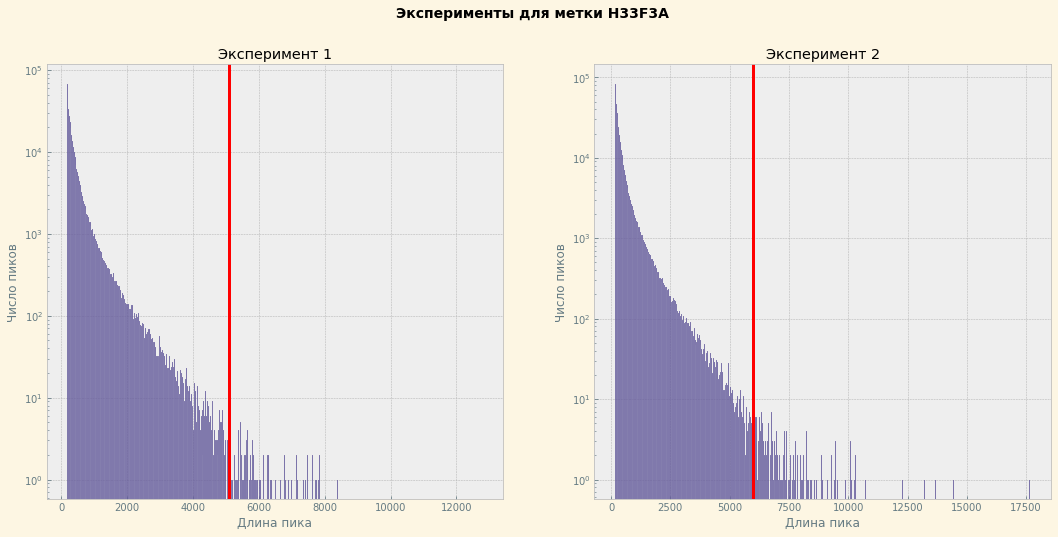

In [78]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('bmh')
cols = ['chrom', 'start', 'end', 'name', 'score']
borders = [5100, 6000]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
plt.suptitle('Эксперименты для метки H33F3A', fontweight='bold', fontsize=14, c='black')
seq = ['H3F3A.ENCFF343MZY.hg19.bed', 'H3F3A.ENCFF066CSA.hg19.bed']
for index in range(2):
    df = pd.read_csv('{}'.format(seq[index]), sep='\t', header=None)
    df.columns = cols
    df['length'] = df.end - df.start
    sns.histplot(ax=ax[index], data=df, x='length', bins=500, log_scale=[False, True], color='darkslateblue')
    ax[index].set(xlabel="Длина пика", ylabel="Число пиков", title="Эксперимент {}".format(1 + index))
    ax[index].axvline(x=borders[index], color='red', lw=3)
    print(seq[index], 'contains', df['name'].count(), 'peaks')
plt.show()

#### I.III Фильтрация экспериментов от выбросов

In [38]:
!cat H3F3A.ENCFF343MZY.hg19.bed | awk '$3-$2<5100' > H3F3A.ENCFF343MZY.hg19.filtered.bed 
!cat H3F3A.ENCFF066CSA.hg19.bed | awk '$3-$2<6000' > H3F3A.ENCFF066CSA.hg19.filtered.bed

#### I.IV Построение гистограмм распределения длин пиков после фильтрации

H3F3A.ENCFF343MZY.hg19.bed contains 314765 peaks
H3F3A.ENCFF066CSA.hg19.bed contains 376217 peaks


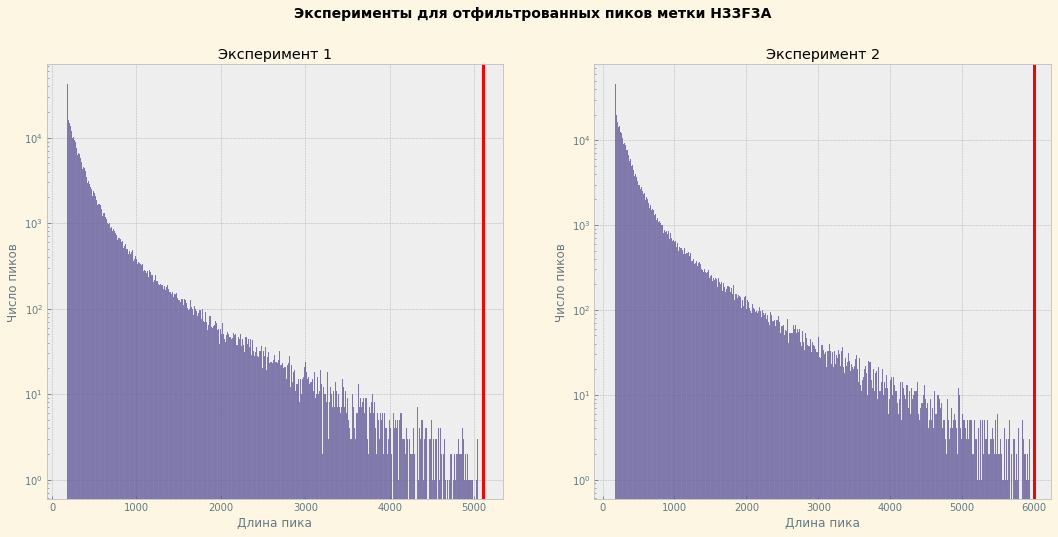

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
plt.suptitle('Эксперименты для отфильтрованных пиков метки H33F3A', fontweight='bold', fontsize=14, c='black')
seq_filter = ['H3F3A.ENCFF343MZY.hg19.filtered.bed', 'H3F3A.ENCFF066CSA.hg19.filtered.bed']
for index in range(2):
    df = pd.read_csv('{}'.format(seq_filter[index]), sep='\t', header=None)
    df.columns = cols
    df['length'] = df.end - df.start
    sns.histplot(ax=ax[index], data=df, x='length', bins=500, log_scale=[False, True], color='darkslateblue')
    ax[index].set(xlabel="Длина пика", ylabel="Число пиков", title="Эксперимент {}".format(1 + index))
    ax[index].axvline(x=borders[index], color='red', lw=3)
    print(seq[index], 'contains', df['name'].count(), 'peaks')
plt.show()

#### I.V Анализ расположения пиков относительно аннотированных генов

В данных целях была применена библиотека rpy2 и все связанные модули, позволившие внедрить эффективные функции языка R в рамках программного кода, выполненного посредством Python3.

In [50]:
import rpy2
import rpy2.robjects as robjects

In [ ]:
robjects.r('''
        library(ChIPpeakAnno)
        library(ChIPseeker)
        library(TxDb.Hsapiens.UCSC.hg19.knownGene)
        library(org.Hs.eg.db)

        
        NAME_1 <- 'H3F3A.ENCFF343MZY.hg19.filtered'
        NAME_2 <- 'H3F3A.ENCFF066CSA.hg19.filtered'
        DATA_DIR <- "/Users/andreyborevskiy/Downloads/"
        OUT_DIR <- "/Users/andreyborevskiy/Downloads/"
        
        peaks_1 <- toGRanges(paste0(DATA_DIR, NAME_1, '.bed'), format="BED")
        peaks_2 <- toGRanges(paste0(DATA_DIR, NAME_2, '.bed'), format="BED")
        txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene
        
        peakAnno_1 <- annotatePeak(peaks_1, tssRegion=c(-3000, 3000), TxDb=txdb, annoDb="org.Hs.eg.db")
        peakAnno_2 <- annotatePeak(peaks_2, tssRegion=c(-3000, 3000), TxDb=txdb, annoDb="org.Hs.eg.db")
        
        png(paste0(OUT_DIR, NAME_1, '.plotAnnoPie.png'))
        png(paste0(OUT_DIR, NAME_2, '.plotAnnoPie.png'))
        
        plotAnnoPie(peakAnno_1)
        dev.off()
        plotAnnoPie(peakAnno_2)
        dev.off()

''')

#### I.VI Объединение двух наборов отфильтрованных ChIP-seq пиков 

In [1]:
!cat *.filtered.bed | sort -k1,1 -k2,2n | bedtools merge > H3F3A.merge.hg19.bed

## II. Анализ участков вторичной стр-ры ДНК
------

В качестве вторичной структуры ДНК были выбраны **Квадруплексы**

Полученные с помощью G4-seq

Название изучаемого образца - **Homo_Li_K**

Общий образец в данном исследовании изначально состоял из двух отдельных файлов:
1. GSM3003539_Homo_all_w15_th-1_minus.hits.max.K.w50.25.bed.gz
2. GSM3003539_Homo_all_w15_th-1_plus.hits.max.K.w50.25.bed.gz

#### II.I Объединение образцов

In [2]:
!cat quadro_1.bed quadro_2.bed | sort -k1,1 -k2,2n | bedtools merge > Quadruplexes_LI_K.bed

#### II.II Построение распределения длин участков вторичной стр-ры ДНК

Quadruplexes Homo_Li_K file contains 428624 peaks


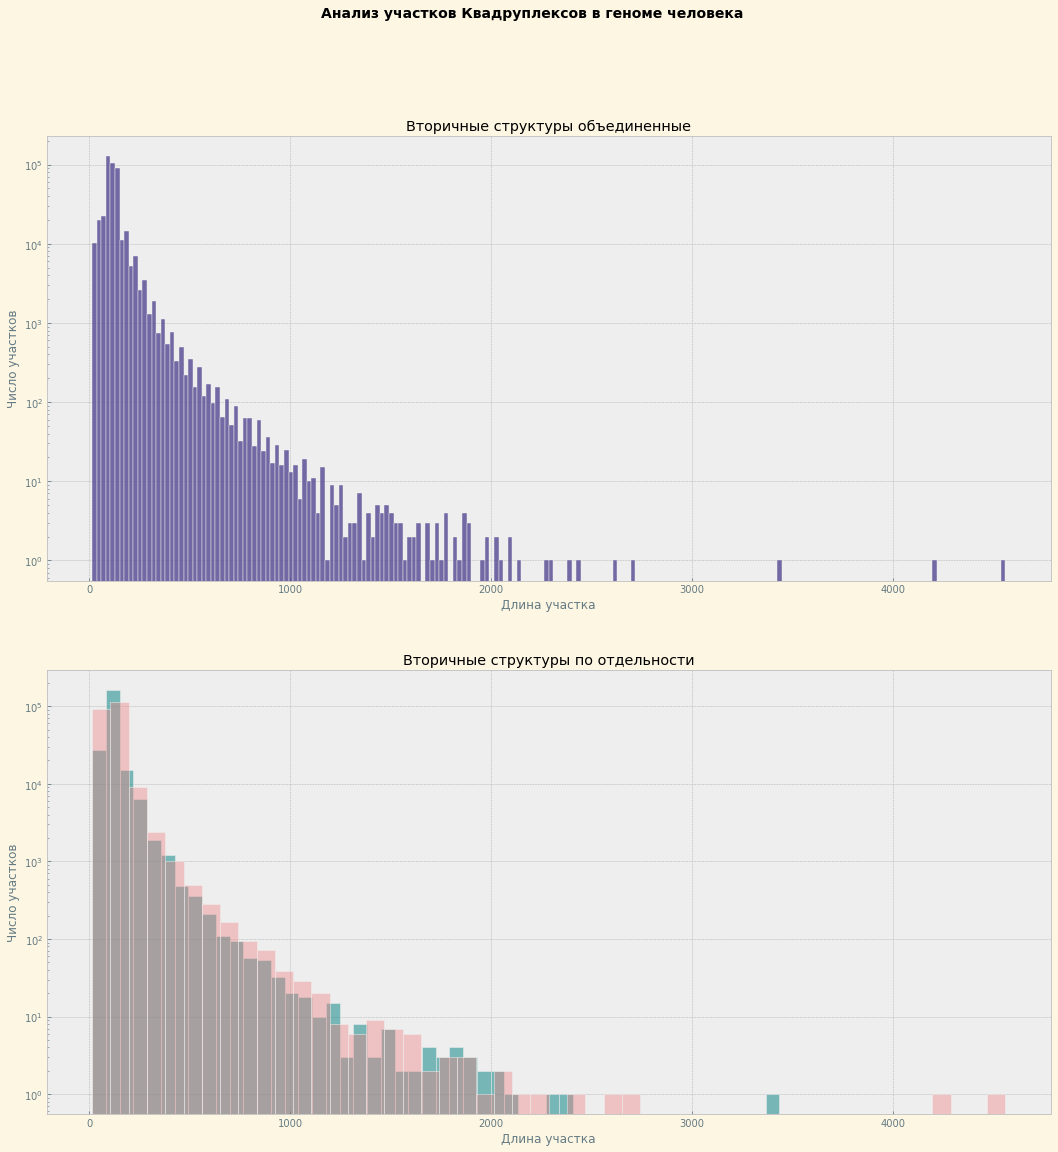

In [83]:
df = pd.read_csv('Quadruplexes_Li_K.bed', sep='\t', header=None)
df_1 = pd.read_csv('quadro_1.bed', sep='\t', header=None)
df_2 = pd.read_csv('quadro_2.bed', sep='\t', header=None)

cols = ['chrome', 'start', 'end', 'score']
df_1.columns = cols
df_2.columns = cols
cols.pop()
df.columns = cols

df['length'] = df.end - df.start
df_1['length'] = df_1.end - df_1.start
df_2['length'] = df_2.end - df_2.start

print('Quadruplexes Homo_Li_K file contains', df.shape[0], 'peaks')

fig, ax = plt.subplots(figsize=(18, 18), nrows=2, ncols=1)
plt.suptitle("Анализ участков Квадруплексов в геноме человека", fontweight='bold', fontsize=14, c='black')
sns.histplot(ax=ax[0], data=df, x='length', bins=200, log_scale=[False, True], color='darkslateblue')
ax[0].set(xlabel="Длина участка", ylabel="Число участков", title="Вторичные структуры объединенные")


sns.histplot(ax=ax[1], data=df_1, x='length', bins=50, log_scale=[False, True], color='teal', alpha=0.5)
sns.histplot(ax=ax[1], data=df_2, x='length', bins=50, log_scale=[False, True], color='lightcoral', alpha=0.4)
ax[1].set(xlabel="Длина участка", ylabel="Число участков", title="Вторичные структуры по отдельности")
plt.show()

#### II.III Анализ расположения участков стр-ры ДНК относительно аннотированных генов

In [ ]:
robjects.r('''
        library(ChIPpeakAnno)
        library(ChIPseeker)
        library(TxDb.Hsapiens.UCSC.hg19.knownGene)
        library(org.Hs.eg.db)

        
        Quadro <- 'Quadruplexes_LI_K'
        DATA_DIR <- "/Users/andreyborevskiy/Downloads/"
        OUT_DIR <- "/Users/andreyborevskiy/Downloads/"
        
        peaks <- toGRanges(paste0(DATA_DIR, Quadro, '.bed'), format="BED")
        txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene
        
        peakAnno <- annotatePeak(peaks, tssRegion=c(-3000, 3000), TxDb=txdb, annoDb="org.Hs.eg.db")
        
        png(paste0(OUT_DIR, Quadro, '.plotAnnoPie.png'))
        
        plotAnnoPie(peakAnno)
        dev.off()

''')

## III. Анализ пересечений гистоновой метки и стр-ры ДНК
-----

#### III.I Пересечение гистоновой меткой и Квадруплекса

In [53]:
!bedtools intersect -a Quadruplexes_LI_K.bed -b H3F3A.merge.hg19.bed > H3F3A.intersect_with_Quadro.bed

#### III.II Построение гистограммы длин пересечений

Number of intersections between Quadruplexes and histone marks is equal to 67704


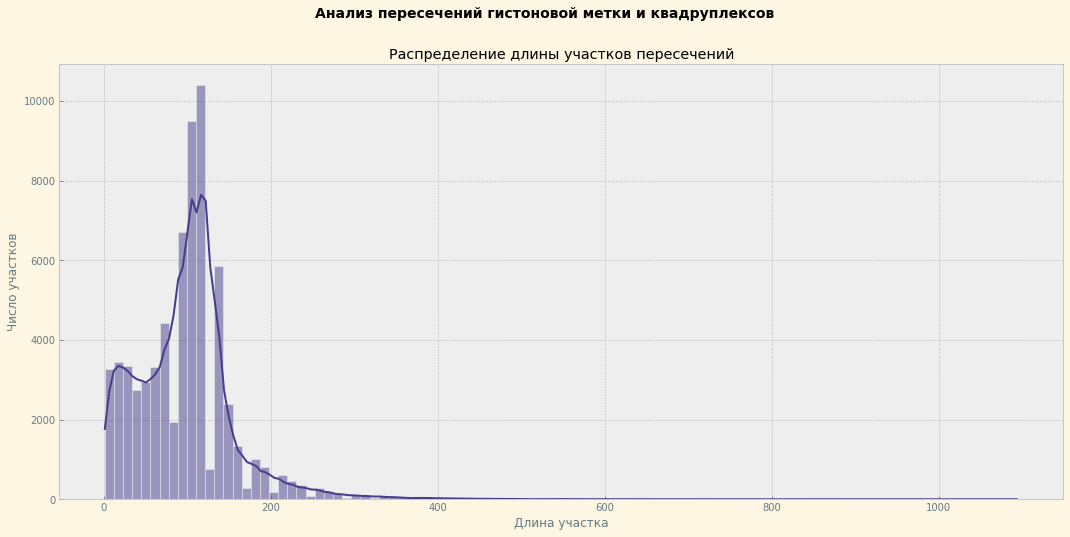

In [84]:
df = pd.read_csv('H3F3A.intersect_with_Quadro.bed', sep='\t', header=None)

df.columns = cols

df['length'] = df.end - df.start
print('Number of intersections between Quadruplexes and histone marks is equal to', df.shape[0])

fig, ax = plt.subplots(figsize=(18, 8))
plt.suptitle("Анализ пересечений гистоновой метки и квадруплексов", fontweight='bold', fontsize=14, c='black')
sns.histplot(data=df, x='length', bins=100, log_scale=[False, False], color='darkslateblue', kde=True)
ax.set(xlabel="Длина участка", ylabel="Число участков", title="Распределение длины участков пересечений")
plt.show()

#### III.III Анализ расположения пересечений относительно аннотированных генов

In [ ]:
robjects.r('''
        library(ChIPpeakAnno)
        library(ChIPseeker)
        library(TxDb.Hsapiens.UCSC.hg19.knownGene)
        library(org.Hs.eg.db)

        
        Intersect <- 'H3F3A.intersect_with_Quadro'
        DATA_DIR <- "/Users/andreyborevskiy/Downloads/"
        OUT_DIR <- "/Users/andreyborevskiy/Downloads/"
        
        peaks <- toGRanges(paste0(DATA_DIR, Intersect, '.bed'), format="BED")
        txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene
        
        peakAnno <- annotatePeak(peaks, tssRegion=c(-3000, 3000), TxDb=txdb, annoDb="org.Hs.eg.db")
        
        png(paste0(OUT_DIR, Intersect, '.plotAnnoPie.png'))
        
        plotAnnoPie(peakAnno)
        dev.off()

''')

#### III.IV Ассоциирование полученных пересечений с ближайшими генами

In [ ]:
robjects.r('''
        library(ChIPpeakAnno)
        library(TxDb.Hsapiens.UCSC.hg19.knownGene)
        library(org.Hs.eg.db)
        library(magrittr)

DATA_DIR <- "/Users/andreyborevskiy/Downloads/"

peaks <- toGRanges(paste0(DATA_DIR, 'H3F3A.intersect_with_Quadro.bed'), format="BED")
peaks[1:2]

annoData <- toGRanges(TxDb.Hsapiens.UCSC.hg19.knownGene)
annoData[1:2]


anno <- annotatePeakInBatch(peaks, AnnotationData=annoData, 
                            output="overlapping", 
                            FeatureLocForDistance="TSS",
                            bindingRegion=c(-2000, 300))
data.frame(anno) %>% head()

anno$symbol <- xget(anno$feature, org.Hs.egSYMBOL)
data.frame(anno) %>% head()

anno_df <- data.frame(anno)
write.table(anno_df, file=paste0(DATA_DIR, 'Quadro.intersect.genes.txt'),
            col.names = TRUE, row.names = FALSE, sep = '\t', quote = FALSE)

uniq_genes_df <- unique(anno_df['symbol'])
write.table(uniq_genes_df, file=paste0(DATA_DIR, 'Quadro.intersect.genes_uniq.txt'),
            col.names = FALSE, row.names = FALSE, sep = '\t', quote = FALSE)

''')

In [102]:
with open(r"./Quadro.intersect.genes.txt", 'r') as fp, open(r"./Quadro.intersect.genes_uniq.txt", 'r') as fpp:
    x = len(fp.readlines())
    y = len(fpp.readlines())
    print('Total number of peaks associated with genes:', x) 
    print('Total number of unique genes:', y) 

Total number of peaks associated with genes: 11378
Total number of unique genes: 7383
